<a href="https://colab.research.google.com/github/HasinTaj/Emotion-detetction/blob/main/SER2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Path to the zip file in your Google Drive
zip_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24.zip"

# Destination path after unzipping
extract_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"

# Unzip it only if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Now list folders
print(os.listdir(extract_path))


['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
DATA_PATH = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"


In [ ]:
print(os.listdir(extract_path))


['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
!pip install librosa


In [ ]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Your dataset path
extract_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"

# Emotion mapping
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Extract emotion from filename
def extract_emotion(filename):
    try:
        emotion_id = filename.split("-")[2]
        return emotion_map.get(emotion_id, "unknown")
    except Exception as e:
        print(f"Error extracting emotion from {filename}: {e}")
        return "unknown"

# Extract MFCC features
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

# Initialize storage
features, labels = [], []

# Loop through actors
for actor in os.listdir(extract_path):
    actor_folder = os.path.join(extract_path, actor)
    if os.path.isdir(actor_folder):
        for file in os.listdir(actor_folder):
            if file.endswith(".wav"):
                try:
                    file_path = os.path.join(actor_folder, file)
                    emotion = extract_emotion(file)
                    if emotion != "unknown":
                        mfccs = extract_features(file_path)
                        features.append(mfccs)
                        labels.append(emotion)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Check results
print("✅ Total processed files:", len(features))
print("✅ Unique emotions:", set(labels))

# Only proceed if data exists
if features and labels:
    X = np.array(features)
    y = LabelEncoder().fit_transform(labels)
    y = to_categorical(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("✅ Preprocessing complete. Shapes:")
    print("X_train:", X_train.shape)
    print("y_train:", y_train.shape)
else:
    print("❌ No data found. Please double-check the dataset path and structure.")


✅ Total processed files: 1440
✅ Unique emotions: {'fearful', 'angry', 'sad', 'calm', 'neutral', 'happy', 'disgust', 'surprised'}
✅ Preprocessing complete. Shapes:
X_train: (1152, 40)
y_train: (1152, 8)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Reshape input for Transformer
X_train_exp = np.expand_dims(X_train, axis=-1)  # shape: (samples, 40, 1)
X_test_exp = np.expand_dims(X_test, axis=-1)

# Define Transformer block
def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    return x + res

# Build Model
input_layer = layers.Input(shape=(40, 1))

# Transformer Encoder
x = transformer_encoder(input_layer)

# 1D CNN Layer
x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)

# Fully connected layers
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(8, activation='softmax')(x)

# Compile model
model = models.Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 40, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 40, 1)          │              2 │ input_layer_1[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 40, 1)          │            897 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 40, 1)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 40, 1)          │              0 │ dropout_1[0][0],       │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 40, 1)          │              2 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 40, 128)        │            256 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 40, 128)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 40, 128)        │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 38, 64)         │         24,640 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ conv1d[0][0]           │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          4,160 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │            520 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,477 (119.05 KB)

 Trainable params: 30,477 (119.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.1451 - loss: 6.0658 - val_accuracy: 0.1493 - val_loss: 2.1410
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1475 - loss: 2.1381 - val_accuracy: 0.2083 - val_loss: 1.9927
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1731 - loss: 2.0332 - val_accuracy: 0.2083 - val_loss: 2.0284
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1920 - loss: 2.0211 - val_accuracy: 0.1979 - val_loss: 2.0280
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1877 - loss: 2.0209 - val_accuracy: 0.2049 - val_loss: 2.0271
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1684 - loss: 2.0255 - val_accuracy: 0.1597 - val_loss: 2.0116
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1557 - loss: 2.0012 - val_accuracy: 0.1806 - val_loss: 2.0018
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1890 - loss: 2.0135 - val_accuracy: 0.2396 - val_los

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3001 - loss: 1.8128 
Test Accuracy: 0.26


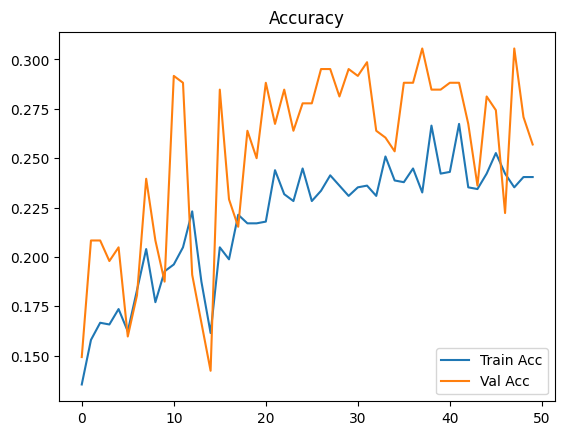

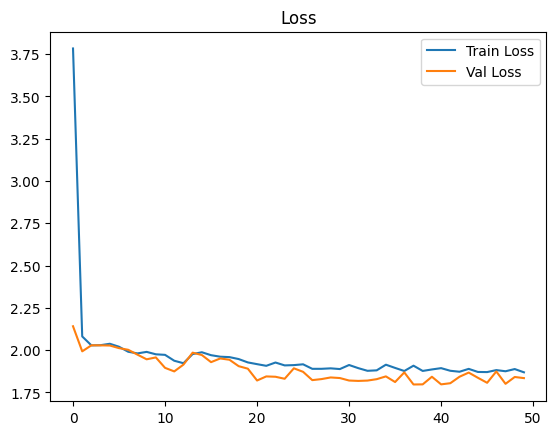

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:
print("X_test_exp shape:", X_test_exp.shape)


X_test_exp shape: (288, 40, 1)


In [ ]:
print("y_test shape:", y_test.shape)


y_test shape: (288, 8)


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# Then re-split with correct labels
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Expand inputs again
X_train_exp = np.expand_dims(X_train, axis=-1)
X_test_exp = np.expand_dims(X_test, axis=-1)


In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (1152, 40)
X_test shape: (288, 40)


In [ ]:
# Expand dimensions for CNN
X_train_exp = np.expand_dims(X_train, axis=-1)
X_test_exp = np.expand_dims(X_test, axis=-1)

print("X_train_exp shape:", X_train_exp.shape)  # Should be (samples, 40, 1)
print("X_test_exp shape:", X_test_exp.shape)


X_train_exp shape: (1152, 40, 1)
X_test_exp shape: (288, 40, 1)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add

input_layer = Input(shape=(40, 1))

# CNN
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = LayerNormalization()(x)

# Multi-head self-attention
attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = Add()([x, attn_output])  # Residual connection
x = LayerNormalization()(x)

# Feedforward
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Pooling and Output
x = GlobalAveragePooling1D()(x)
output_layer = Dense(8, activation='softmax')(x)

# Compile
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 40, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 40, 64)         │            256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 40, 64)         │            128 │ conv1d_1[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 40, 64)         │         33,216 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 40, 64)         │              0 │ layer_normalization_2… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 40, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 40, 128)        │          8,320 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 40, 128)        │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ dropout_5[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 8)              │          1,032 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 43,080 (168.28 KB)

 Trainable params: 43,080 (168.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train_exp, y_train, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.1414 - loss: 2.1351 - val_accuracy: 0.1688 - val_loss: 2.0571
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1878 - loss: 2.0291 - val_accuracy: 0.2078 - val_loss: 2.0376
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2164 - loss: 2.0111 - val_accuracy: 0.1299 - val_loss: 2.0498
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2031 - loss: 2.0023 - val_accuracy: 0.1775 - val_loss: 2.0041
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2640 - loss: 1.9275 - val_accuracy: 0.2597 - val_loss: 1.9117
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2711 - loss: 1.8867 - val_accuracy: 0.2121 - val_loss: 1.9392
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2912 - loss: 1.8670 - val_accuracy: 0.2424 - val_loss: 1.9118
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2578 - loss: 1.8586 - val_accuracy: 0.2121 - val_lo

In [ ]:
loss, acc = model.evaluate(X_test_exp, y_test)
print(f"\n✅ Final Accuracy: {acc * 100:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3625 - loss: 1.7967 

✅ Final Accuracy: 36.81%


In [ ]:
# ✅ Install Dependencies
!pip install librosa

# ✅ Import Libraries
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Feature Extraction with MFCC + Delta + Delta-Delta
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    combined = np.vstack((mfcc, delta, delta2))  # Shape: (120, time)
    return np.mean(combined.T, axis=0)  # Final shape: (120,)

# ✅ Load Data (Update with your dataset path)
data_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"
labels = []
features = []

emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            try:
                features.append(extract_features(file_path))
                emotion = emotion_map[file.split("-")[2]]
                labels.append(emotion)
            except:
                print("Error processing:", file_path)

# ✅ Preprocess Data
X = np.array(features)
y = to_categorical(LabelEncoder().fit_transform(labels))
X = np.expand_dims(X, axis=-1)  # (samples, 120, 1)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define Stronger Model
input_layer = Input(shape=(120, 1))
x = Conv1D(128, 5, activation='relu', padding='same')(input_layer)
x = LayerNormalization()(x)

# Attention Block 1
attn_1 = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = Add()([x, attn_1])
x = LayerNormalization()(x)

# Attention Block 2
attn_2 = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = Add()([x, attn_2])
x = LayerNormalization()(x)

# Feedforward
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = GlobalAveragePooling1D()(x)
output_layer = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ✅ Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

# ✅ Train Model
model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2,
          callbacks=[early_stop, reduce_lr])

# ✅ Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Final Test Accuracy: {acc * 100:.2f}%")


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 120, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 120, 128)       │            768 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 120, 128)       │            256 │ conv1d_10[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_9    │ (None, 120, 128)       │        131,968 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 120, 128)       │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 120, 128)       │            256 │ add_13[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_10   │ (None, 120, 128)       │        131,968 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 120, 128)       │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_17    │ (None, 120, 128)       │            256 │ add_14[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 120, 256)       │         33,024 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 120, 256)       │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ dropout_27[0][0]       │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 8)              │          2,056 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 300,552 (1.15 MB)

 Trainable params: 300,552 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.1287 - loss: 2.1802 - val_accuracy: 0.1688 - val_loss: 2.0419 - learning_rate: 0.0010
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1653 - loss: 2.0392 - val_accuracy: 0.1472 - val_loss: 2.1041 - learning_rate: 0.0010
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2046 - loss: 2.0131 - val_accuracy: 0.1602 - val_loss: 2.0513 - learning_rate: 0.0010
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2691 - loss: 1.9303 - val_accuracy: 0.1732 - val_loss: 1.9865 - learning_rate: 0.0010
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2475 - loss: 1.9018 - val_accuracy: 0.1861 - val_loss: 1.9751 - learning_rate: 0.0010
Epoch 6/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2803 - loss: 1.8869 - val_accuracy: 0.1905 - val_loss: 1.9960 - learning_rate: 0.0010
Epoch 7/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2957 - loss: 1.8059 - val_a

In [ ]:
# ✅ Install Dependencies
!pip install librosa

# ✅ Import Libraries
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, GlobalAveragePooling1D, Dense,
                                     LayerNormalization, Dropout, MultiHeadAttention,
                                     Add, BatchNormalization, MaxPooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Feature Extraction with MFCC + Delta + Delta-Delta
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    combined = np.vstack((mfcc, delta, delta2))  # Shape: (120, time)
    return combined.T  # shape: (time, 120)

# ✅ Load Data (Update with your dataset path)
data_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"
labels = []
features = []

emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            try:
                feat = extract_features(file_path)
                features.append(feat)
                emotion = emotion_map[file.split("-")[2]]
                labels.append(emotion)
            except:
                print("Error processing:", file_path)

# ✅ Pad Sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(features, dtype='float32', padding='post', maxlen=300)  # Shape: (samples, time_steps, 120)
y = to_categorical(LabelEncoder().fit_transform(labels))

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define Stronger Model
input_layer = Input(shape=(300, 120))
x = Conv1D(256, 5, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2)(x)
x = BatchNormalization()(x)

# Attention Block 1
attn_1 = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
x = Add()([x, attn_1])
x = LayerNormalization()(x)

# Attention Block 2
attn_2 = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
x = Add()([x, attn_2])
x = LayerNormalization()(x)

# Feedforward
x = Conv1D(256, 3, activation='relu', padding='same')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ✅ Callbacks
early_stop = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=7)

# ✅ Train Model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
          callbacks=[early_stop, reduce_lr])

# ✅ Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Final Test Accuracy: {acc * 100:.2f}%")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 300, 120)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 300, 256)       │        153,856 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 150, 256)       │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 150, 256)       │          1,024 │ max_pooling1d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 150, 256)       │        526,080 │ batch_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 150, 256)       │              0 │ batch_normalization[0… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 150, 256)       │            512 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 150, 256)       │        526,080 │ layer_normalization_7… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 150, 256)       │              0 │ layer_normalization_7… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 150, 256)       │            512 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 150, 256)       │        196,864 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ conv1d_4[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │         65,792 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 256)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)      

 Total params: 1,472,776 (5.62 MB)

 Trainable params: 1,472,264 (5.62 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.2213 - loss: 2.0123 - val_accuracy: 0.0996 - val_loss: 3.9407 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.3323 - loss: 1.7108 - val_accuracy: 0.1818 - val_loss: 2.0257 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3727 - loss: 1.6341 - val_accuracy: 0.2294 - val_loss: 2.7359 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4551 - loss: 1.4621 - val_accuracy: 0.3333 - val_loss: 2.3447 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5365 - loss: 1.2777 - val_accuracy: 0.4892 - val_loss: 1.3511 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6064 - loss: 1.0950 - val_accuracy: 0.3636 - val_loss: 2.1174 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6883 - loss: 0.8827 

In [ ]:
data_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"


In [ ]:
import os

# Print contents of the folder to check
for root, dirs, files in os.walk(data_path):
    print(f"📁 {root} — {len(files)} files")
    break  # just check top level


📁 /content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24 — 0 files


In [ ]:
import librosa

# Test a single audio file
test_file = None
for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            test_file = os.path.join(root, file)
            break
    if test_file:
        break

if test_file:
    print("🎧 Found file:", test_file)
    y, sr = librosa.load(test_file, sr=16000)
    print("✅ Sample loaded, duration:", librosa.get_duration(y=y, sr=sr), "seconds")
else:
    raise FileNotFoundError("❌ No .wav files found in dataset folder.")


🎧 Found file: /content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
✅ Sample loaded, duration: 3.3033125 seconds


In [ ]:
import os
import librosa
import numpy as np
import tensorflow_hub as hub

# Load YAMNet model once
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Emotion code map (from RAVDESS filenames)
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_yamnet_embedding(audio):
    """Extract embedding from YAMNet"""
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return np.mean(embeddings.numpy(), axis=0)

def augment_audio(audio, sr):
    """Basic augmentation: original, noise, pitch"""
    aug = [audio]

    # Add noise
    noise = np.random.normal(0, 0.005, audio.shape)
    aug.append(audio + noise)

    # Pitch shift
    aug.append(librosa.effects.pitch_shift(audio, sr, n_steps=2))

    return aug

# ✅ Dataset path
data_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"

# ✅ Feature + label containers
features = []
labels = []

# ✅ Loop through dataset
for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            try:
                file_path = os.path.join(root, file)
                audio, sr = librosa.load(file_path, sr=16000)

                # Apply augmentations
                for sample in augment_audio(audio, sr):
                    emb = extract_yamnet_embedding(sample)

                    emotion_code = file.split("-")[2]
                    emotion = emotion_map.get(emotion_code)

                    if emotion:
                        features.append(emb)
                        labels.append(emotion)

            except Exception as e:
                print("⚠️ Skipping file:", file, "Error:", str(e))

print("✅ Total extracted:", len(features), "samples")


⚠️ Skipping file: 03-01-01-01-01-01-01.wav Error: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
⚠️ Skipping file: 03-01-01-01-01-02-01.wav Error: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
⚠️ Skipping file: 03-01-01-01-02-01-01.wav Error: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
⚠️ Skipping file: 03-01-01-01-02-02-01.wav Error: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
⚠️ Skipping file: 03-01-02-01-01-01-01.wav Error: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
⚠️ Skipping file: 03-01-02-01-01-02-01.wav Error: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
⚠️ Skipping file: 03-01-02-01-02-01-01.w

In [ ]:
print("✅ Number of features:", len(features))
print("✅ Number of labels:", len(labels))
print("🧪 Sample labels:", labels[:5])


✅ Number of features: 0
✅ Number of labels: 0
🧪 Sample labels: []


In [ ]:
import os

data_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"

wav_files = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            wav_files.append(os.path.join(root, file))

print(f"🎧 Found {len(wav_files)} .wav files")
print("🧪 First file:", wav_files[0] if wav_files else "❌ No file found")


🎧 Found 1440 .wav files
🧪 First file: /content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav


In [ ]:
file = os.path.basename(wav_files[0])
print("📄 Filename:", file)
print("🧩 Parts:", file.split("-"))


📄 Filename: 03-01-01-01-01-01-01.wav
🧩 Parts: ['03', '01', '01', '01', '01', '01', '01.wav']


In [ ]:
import librosa
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf

yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

def extract_yamnet_embedding(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return np.mean(embeddings.numpy(), axis=0)

# Try first audio file
audio, sr = librosa.load(wav_files[0], sr=16000)
emb = extract_yamnet_embedding(audio)
print("✅ Embedding shape:", emb.shape)


✅ Embedding shape: (1024,)


In [ ]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

features = []
labels = []

for file_path in wav_files:
    try:
        file = os.path.basename(file_path)
        audio, sr = librosa.load(file_path, sr=16000)
        emb = extract_yamnet_embedding(audio)

        parts = file.split("-")
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = emotion_map.get(emotion_code)
            if emotion:
                features.append(emb)
                labels.append(emotion)
    except Exception as e:
        print("❌ Error processing", file_path, str(e))

print("✅ Loaded:", len(features), "features")


✅ Loaded: 1440 features


In [ ]:
# 📦 Install required packages (if not installed already)
!pip install tensorflow tensorflow-hub librosa scikit-learn --quiet

# 📁 Step 1: Load Audio & Extract Embeddings
import os
import numpy as np
import librosa
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv1D, GlobalAveragePooling1D, MultiHeadAttention,
    LayerNormalization, Add, Flatten, Reshape
)

data_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"

# 🔍 Step 1.1: Find WAV files
wav_files = []
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            wav_files.append(os.path.join(root, file))

print(f"🎧 Found {len(wav_files)} audio files")

# 🎯 Step 1.2: Emotion Mapping
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

def extract_yamnet_embedding(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    _, embeddings, _ = yamnet_model(waveform)
    return np.mean(embeddings.numpy(), axis=0)

features, labels = [], []
for file_path in wav_files:
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        emb = extract_yamnet_embedding(audio)

        file = os.path.basename(file_path)
        parts = file.split("-")
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = emotion_map.get(emotion_code)
            if emotion:
                features.append(emb)
                labels.append(emotion)
    except Exception as e:
        print("❌ Error processing", file_path, str(e))

print("✅ Total Samples:", len(features))

# 🔠 Step 2: Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y = to_categorical(y_encoded)
X = np.array(features)

# 🧪 Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🔧 Step 4: Reshape for CNN
X_train_exp = np.expand_dims(X_train, axis=-1)
X_test_exp = np.expand_dims(X_test, axis=-1)

# 🧠 Step 5: Build Model (CNN + Transformer Encoder)
def transformer_block(x, head_size, num_heads, ff_dim, dropout=0):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    attn = Dropout(dropout)(attn)
    x = Add()([x, attn])
    x = LayerNormalization(epsilon=1e-6)(x)

    ffn = Dense(ff_dim, activation="relu")(x)
    ffn = Dropout(dropout)(ffn)
    x = Add()([x, ffn])
    return LayerNormalization(epsilon=1e-6)(x)

input_layer = Input(shape=(X.shape[1], 1))
x = Conv1D(128, 5, activation="relu")(input_layer)
x = transformer_block(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(y.shape[1], activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 🚀 Step 6: Train
history = model.fit(X_train_exp, y_train, epochs=100, batch_size=32,
                    validation_split=0.1, verbose=1)

# 🎯 Step 7: Evaluate
loss, acc = model.evaluate(X_test_exp, y_test)
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")

# 🔍 Step 8: Predict Emotion from New Audio
def predict_emotion(file_path):
    audio, _ = librosa.load(file_path, sr=16000)
    emb = extract_yamnet_embedding(audio)
    emb_exp = np.expand_dims(emb, axis=(0, -1))
    pred = model.predict(emb_exp)[0]
    emotion = label_encoder.inverse_transform([np.argmax(pred)])[0]
    print(f"🗣️ Predicted Emotion: {emotion} ({np.max(pred)*100:.2f}%)")

# 🧪 Example
# predict_emotion("/content/drive/MyDrive/sample.wav")


🎧 Found 1440 audio files
✅ Total Samples: 1440
Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 305ms/step - accuracy: 0.1314 - loss: 2.1811 - val_accuracy: 0.1638 - val_loss: 2.0890
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.1230 - loss: 2.0790 - val_accuracy: 0.1379 - val_loss: 2.1048
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.1608 - loss: 2.0374 - val_accuracy: 0.1466 - val_loss: 2.0571
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.1288 - loss: 2.0453 - val_accuracy: 0.1897 - val_loss: 2.0226
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.1683 - loss: 2.0265 - val_accuracy: 0.1379 - val_loss: 2.0560
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.1508 - loss: 2.0245 - val_accuracy: 0.1897 - val_loss: 2.0207
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.1850 - loss: 2.0392 - val_accuracy: 0.1724 - val_loss: 2.0096
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - a

In [ ]:
print("Number of features:", len(features))
print("Shape of first feature:", features[0].shape if features else 'None')


Number of features: 1440
Shape of first feature: (1024,)


In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [ ]:
def add_noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape)

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch_shift(data, sr, steps=4):
    return librosa.effects.pitch_shift(data, sr, steps)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, LSTM, Dense, Dropout, Bidirectional, Attention

input_layer = Input(shape=(X_train.shape[1], 1))
x = Conv1D(128, 5, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Attention()([x, x])
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output_shape)


y_train shape: (1152, 8)
Model output shape: (None, 1020, 8)


In [ ]:
Dense(8, activation='softmax')  # For 8 emotion classes


<Dense name=dense_14, built=False>

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)  # Convert to integers
y = to_categorical(y_encoded, num_classes=8)     # One-hot encode


In [ ]:
X = np.array(features)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Add 1 channel for Conv1D


In [ ]:
print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)


✅ X shape: (1440, 1024, 1)
✅ y shape: (1440, 8)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(3))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))  # 8 emotion classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.1700 - loss: 2.0642 - val_accuracy: 0.1818 - val_loss: 2.0653 - learning_rate: 0.0010
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1729 - loss: 2.0249 - val_accuracy: 0.2165 - val_loss: 2.0618 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2065 - loss: 1.9895 - val_accuracy: 0.2294 - val_loss: 2.0446 - learning_rate: 0.0010
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1756 - loss: 2.0083 - val_accuracy: 0.1688 - val_loss: 2.0344 - learning_rate: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2199 - loss: 1.9731 - val_accuracy: 0.2381 - val_loss: 2.0254 - learning_rate: 0.0010
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1937 - loss: 1.9943 - val_accuracy: 0.2121 - val_loss: 2.0154 - learning_rate: 0.0010
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2082 - loss: 1.9460 - val_acc

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Final Accuracy: {acc * 100:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3334 - loss: 1.7319
✅ Final Accuracy: 32.64%


In [ ]:
# ✅ 1. Setup
!pip install tensorflow tensorflow_hub librosa --quiet

import os
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 2. Load and Extract Features
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

def extract_yamnet_embedding(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
        scores, embeddings, spectrogram = yamnet_model(waveform)
        return tf.reduce_mean(embeddings, axis=0).numpy()
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def get_emotion_from_filename(filename):
    emotion_map = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    emotion_id = filename.split('-')[2]
    return emotion_map.get(emotion_id)

# ✅ 3. Load Dataset
data_dir = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"
features, labels = [], []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):
            emotion = get_emotion_from_filename(file)
            if emotion:
                emb = extract_yamnet_embedding(os.path.join(root, file))
                if emb is not None:
                    features.append(emb)
                    labels.append(emotion)

X = np.array(features)
y_encoded = LabelEncoder().fit_transform(labels)
y = to_categorical(y_encoded)

print("✅ Data loaded. Features:", X.shape, "Labels:", y.shape)

# ✅ 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# ✅ 5. Transformer Encoder Layer
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])
    x2 = LayerNormalization(epsilon=1e-6)(x)
    x2 = Dense(ff_dim, activation="relu")(x2)
    x2 = Dropout(dropout)(x2)
    x2 = Dense(inputs.shape[-1])(x2)
    return Add()([x, x2])

# ✅ 6. Build Model
input_layer = Input(shape=(X_train.shape[1], 1))
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ 7. Train Model
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.2, callbacks=callbacks)

# ✅ 8. Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🎯 Final Test Accuracy: {acc * 100:.2f}%")

# ✅ 9. Predict a New File
def predict_emotion(file_path):
    emb = extract_yamnet_embedding(file_path)
    if emb is None:
        return "❌ Could not process the audio."
    emb = emb[np.newaxis, ..., np.newaxis]
    pred = model.predict(emb)
    emotion_idx = np.argmax(pred)
    emotion = LabelEncoder().fit(labels).classes_[emotion_idx]
    return f"Predicted Emotion: {emotion} ({np.max(pred) * 100:.2f}%)"

# Example:
# print(predict_emotion('/content/drive/MyDrive/test_audio.wav'))


✅ Data loaded. Features: (1440, 1024) Labels: (1440, 8)
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 540ms/step - accuracy: 0.1415 - loss: 7.1276 - val_accuracy: 0.1688 - val_loss: 2.0515
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.1235 - loss: 2.0907 - val_accuracy: 0.1299 - val_loss: 2.0771
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.1338 - loss: 2.0749 - val_accuracy: 0.1299 - val_loss: 2.0749
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.1074 - loss: 2.0750 - val_accuracy: 0.1169 - val_loss: 2.0729
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.1557 - loss: 2.0733 - val_accuracy: 0.1169 - val_loss: 2.0708
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.1058 - loss: 2.0709 - val_accuracy: 0.1169 - val_loss: 2.0693

🎯 Final Test Accuracy: 18.06%


In [ ]:
# 📦 Import Libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# 📂 Path to RAVDESS
dataset_path = "/content/drive/MyDrive/RAVDESS1/Audio_Speech_Actors_01-24"

# 🎵 Emotion Mapping
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

# 🎯 Transformer Block
def transformer_block(inputs, head_size=64, num_heads=4, ff_dim=64, rate=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    attn_output = Dropout(rate)(attn_output)
    x = Add()([x, attn_output])

    # Match dimensions for residual connection
    x_res = LayerNormalization(epsilon=1e-6)(x)
    ff_output = Dense(ff_dim, activation='relu')(x_res)
    ff_output = Dense(x.shape[-1])(ff_output)
    ff_output = Dropout(rate)(ff_output)
    return Add()([x, ff_output])

# 🎧 Feature Extraction using YAMNet
yamnet_model = tf.keras.models.load_model('https://storage.googleapis.com/audioset/yamnet.h5')
def extract_yamnet_embedding(audio_path):
    try:
        wav, sr = librosa.load(audio_path, sr=16000)
        waveform = tf.convert_to_tensor(wav, dtype=tf.float32)
        waveform = tf.reshape(waveform, [1, -1])
        _, embeddings, _ = yamnet_model(waveform)
        return np.mean(embeddings.numpy(), axis=0)  # (1024,)
    except Exception as e:
        print(f"Error: {e}")
        return None

# 📊 Load Dataset
features, labels = [], []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split("-")
            emotion = emotion_map.get(parts[2])
            if emotion:
                path = os.path.join(root, file)
                embedding = extract_yamnet_embedding(path)
                if embedding is not None:
                    features.append(embedding)
                    labels.append(emotion)

# ✅ Prepare Data
X = np.array(features)
y = LabelEncoder().fit_transform(labels)
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Features shape: {X.shape}, Labels shape: {y.shape}")

# 🧠 Build Model
input_layer = Input(shape=(1024,))
reshaped = Reshape((1024, 1))(input_layer)
x = Conv1D(64, kernel_size=3, padding="same", activation="relu")(reshaped)
x = transformer_block(x, head_size=64, num_heads=4, ff_dim=64)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(y.shape[1], activation="softmax")(x)
model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 📈 Train Model
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks)

# 🧪 Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")

# 🔍 Predict Emotion on New Audio
def predict_emotion(audio_path):
    embedding = extract_yamnet_embedding(audio_path)
    if embedding is not None:
        pred = model.predict(np.expand_dims(embedding, axis=0))[0]
        emotion = np.argmax(pred)
        confidence = np.max(pred)
        emotion_label = LabelEncoder().fit(labels).classes_[emotion]
        print(f"\n🔊 Predicted Emotion: {emotion_label} ({confidence*100:.2f}%)")
    else:
        print("❌ Could not process the audio file.")

# 🔄 Predict Example:
# predict_emotion("/content/drive/MyDrive/your_audio.wav")


UnimplementedError: File system scheme 'https' not implemented (file: 'https://storage.googleapis.com/audioset/yamnet.h5')

In [ ]:
# 📦 Install TensorFlow Hub if not already
!pip install tensorflow_hub

# 📦 Imports
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import librosa

# 🎧 Load YAMNet model from TensorFlow Hub
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# 🧠 Extract YAMNet Embedding
def extract_yamnet_embedding(audio_path):
    try:
        wav, sr = librosa.load(audio_path, sr=16000)  # YAMNet expects 16 kHz audio
        waveform = tf.convert_to_tensor(wav, dtype=tf.float32)
        waveform = tf.reshape(waveform, [1, -1])
        scores, embeddings, spectrogram = yamnet_model(waveform)
        return np.mean(embeddings.numpy(), axis=0)  # Output shape: (1024,)
    except Exception as e:
        print(f"❌ Error processing {audio_path}: {e}")
        return None


In [ ]:
audio_file = '/content/drive/MyDrive/sample_emotion.wav'
predicted_emotion = predict_emotion()
print(f"🎙️ Predicted Emotion: {predicted_emotion}")